In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df = df.drop(df.columns[[2, 3, 4]], axis=1)

In [5]:
df.columns

Index(['Text', 'Sentiment'], dtype='object')

In [6]:
df_good = df[df.Sentiment == '1']
df_bad = df[df.Sentiment == '0']

In [7]:
df_good = df_good.drop(df_good.columns[[1]], axis=1)
df_bad = df_bad.drop(df_bad.columns[[1]], axis=1)

In [8]:
a = df_good.sample(n=50) 
b = df_bad.sample(n=50) 

In [9]:
l = a.values.tolist()
l2 = b.values.tolist()

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [12]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [14]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [17]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 
nlp.max_length = 20000000

# print(l[0:1])

sentiments = [l, l2]
good_bad = {}

for s in range(0, len(sentiments)):
    texto = str(sentiments[s])
    data = split_pdf(texto)
    # print(data)

    data = first_clear(data)
    # print(data)

    data = list(sent_to_words(data))

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data)

    aggregate = {}
    list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]
    
    for i in range(0, len(list_pos)):
        l = []
        data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

        bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
        # Form Bigrams
        data_words_bigrams = make_bigrams(data_filtered)
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

        id2word = corpora.Dictionary(data_lemmatized)
        texts = data_lemmatized
        corpus = [id2word.doc2bow(text) for text in texts]
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                                update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

        l.append(list_pos[i])
        l.append(data_lemmatized)
        l.append(id2word)
        l.append(corpus)
        l.append(lda_model)
        l.append(ldamallet)
        aggregate[i] = l
    
    good_bad[s] = aggregate


hey


# Tópicos apenas levando em conta os Substantivos

In [29]:
pprint(good_bad[0][0][4].print_topics())
doc_lda = good_bad[0][0][4][good_bad[0][0][3]]

[(0,
  '0.091*"movie" + 0.029*"people" + 0.026*"watch" + 0.020*"scene" + '
  '0.020*"year" + 0.010*"star" + 0.009*"fighting" + 0.008*"chick" + '
  '0.006*"childhood" + 0.005*"difference"'),
 (1,
  '0.053*"time" + 0.029*"love" + 0.026*"episode" + 0.025*"anyone" + '
  '0.020*"stereotype" + 0.017*"end" + 0.012*"child" + 0.010*"fan" + '
  '0.009*"history" + 0.008*"page"'),
 (2,
  '0.212*"thank" + 0.020*"series" + 0.017*"actor" + 0.013*"day" + 0.012*"part" '
  '+ 0.011*"romance" + 0.010*"cast" + 0.007*"minute" + 0.007*"comedy" + '
  '0.007*"horror"'),
 (3,
  '0.125*"film" + 0.029*"character" + 0.015*"appearance" + 0.013*"role" + '
  '0.013*"point" + 0.010*"idea" + 0.010*"hand" + 0.010*"boy" + '
  '0.010*"everyone" + 0.008*"hour"'),
 (4,
  '0.188*"rock" + 0.019*"story" + 0.017*"life" + 0.014*"woman" + 0.011*"way" + '
  '0.009*"performance" + 0.009*"war" + 0.009*"plot" + 0.008*"thing" + '
  '0.008*"america"')]


In [30]:
print('\nPerplexity: ', good_bad[0][0][4].log_perplexity(good_bad[0][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][0][4], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.871884960246911

Coherence Score:  0.8417137429578133


In [62]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][0][4], good_bad[0][0][3], good_bad[0][0][2])
pyLDAvis.save_html(vis, 'lda.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.161227  0.083119       1        1  30.384026
2      0.132755  0.115990       2        1  24.459114
3      0.010771 -0.082753       3        1  17.111620
1      0.011015 -0.075755       4        1  14.678764
0      0.006687 -0.040601       5        1  13.366476, topic_info=     Category        Freq        Term       Total  loglift  logprob
179   Default  178.000000       thank  178.000000  30.0000  30.0000
1249  Default  197.000000        rock  197.000000  29.0000  29.0000
11    Default   73.000000        film   73.000000  28.0000  28.0000
3     Default   42.000000       movie   42.000000  27.0000  27.0000
10    Default   27.000000        time   27.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
1447   Topic5    0.908329   obsession    5.834973   0.1524  -6.2194
1418   Topic5    1.000194     patriot    7.748003  -0.0348  -6.1230
1463   Topic5    0.998696  montgomery    9.572462  -0.2478  -6.1245
1456   Topic5    0.998692       force    9.572466  -0.2478  -6.1245
1389   Topic5    0.889663      denzel    6.686030  -0.0045  -6.2401

[209 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
15        5  0.467216  achievement
529       1  0.877028          act
158       2  0.949533        actor
1148      1  0.743970      actress
560       5  0.684372          air
...     ...       ...          ...
227       4  0.965627         word
328       2  0.773766         work
525       1  0.831020        world
848       2  0.858474        write
292       5  0.919125         year

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [32]:
pprint(good_bad[0][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][0][5], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.029*"actor" + 0.024*"year" + 0.024*"day" + 0.024*"part" + 0.018*"war" + '
  '0.018*"horror" + 0.017*"time" + 0.017*"colman" + 0.017*"episode" + '
  '0.017*"plot"'),
 (1,
  '0.043*"movie" + 0.032*"watch" + 0.031*"man" + 0.022*"murder" + '
  '0.016*"carrie" + 0.015*"point" + 0.015*"dream" + 0.015*"director" + '
  '0.012*"dentist" + 0.012*"home"'),
 (2,
  '0.090*"movie" + 0.061*"character" + 0.036*"scene" + 0.020*"role" + '
  '0.020*"series" + 0.014*"hand" + 0.014*"fact" + 0.012*"columbo" + '
  '0.011*"child" + 0.011*"action"'),
 (3,
  '0.144*"film" + 0.042*"people" + 0.025*"woman" + 0.020*"performance" + '
  '0.019*"time" + 0.017*"book" + 0.017*"show" + 0.014*"smith" + 0.014*"face" + '
  '0.014*"boy"'),
 (4,
  '0.049*"story" + 0.046*"life" + 0.036*"love" + 0.033*"time" + 0.028*"thing" '
  '+ 0.025*"brian" + 0.018*"family" + 0.016*"comedy" + 0.015*"cast" + '
  '0.013*"work"')]

Coherence Score:  0.8467930488112705


In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][0][2], corpus=good_bad[0][0][3], texts=good_bad[0][0][1], start=2, limit=40, step=6)


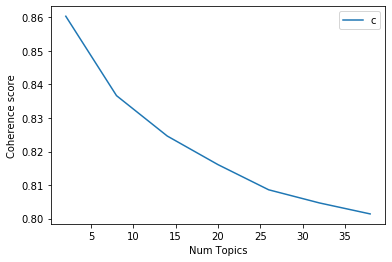

In [34]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [35]:
pprint(good_bad[0][1][4].print_topics())
doc_lda = good_bad[0][1][4][good_bad[0][1][3]]

[(0,
  '0.148*"first" + 0.067*"much" + 0.037*"black" + 0.036*"white" + 0.034*"last" '
  '+ 0.028*"early" + 0.022*"big" + 0.022*"poor" + 0.021*"young" + '
  '0.021*"whole"'),
 (1,
  '0.052*"american" + 0.038*"long" + 0.027*"pretty" + 0.023*"old" + '
  '0.022*"sure" + 0.021*"beautiful" + 0.020*"lovely" + 0.019*"least" + '
  '0.017*"funny" + 0.016*"short"'),
 (2,
  '0.020*"interesting" + 0.017*"likely" + 0.017*"portray" + 0.017*"different" '
  '+ 0.016*"live" + 0.015*"rich" + 0.015*"luke" + 0.013*"von" + 0.012*"fit" + '
  '0.012*"popular"'),
 (3,
  '0.050*"real" + 0.050*"little" + 0.048*"many" + 0.040*"high" + '
  '0.033*"favorite" + 0.023*"several" + 0.022*"dark" + 0.022*"less" + '
  '0.022*"enjoyable" + 0.019*"russian"'),
 (4,
  '0.146*"good" + 0.083*"great" + 0.047*"excellent" + 0.034*"bad" + '
  '0.034*"able" + 0.026*"new" + 0.024*"due" + 0.021*"overall" + '
  '0.021*"realistic" + 0.015*"average"')]


In [36]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.027939773448136

Coherence Score:  0.8426443774438523


In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.153203 -0.191329       1        1  25.899643
0     -0.242262 -0.074773       2        1  21.450708
4      0.052749  0.179613       3        1  18.532393
3      0.025282  0.053979       4        1  17.186779
2      0.011028  0.032510       5        1  16.930475, topic_info=    Category       Freq        Term      Total  loglift  logprob
13   Default  38.000000       first  38.000000   30.000  30.0000
17   Default  33.000000        good  33.000000   29.000  29.0000
0    Default  18.000000       great  18.000000   28.000  28.0000
14   Default  17.000000        much  17.000000   27.000  27.0000
123  Default  16.000000    american  16.000000   26.000  26.0000
..       ...        ...         ...        ...      ...      ...
458   Topic5   1.568674    negative   2.136706    1.467  -4.8605
449   Topic5   1.568674    solitary   2.136706    1.467  -4.8605
453   Topic5   1.568674     certain   2.136706    1.467  -4.8605
455   Topic5   1.568674  mysterious   2.136706    1.467  -4.8605
454   Topic5   1.568674    apparent   2.136706    1.467  -4.8605

[212 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
216       3  0.991925        able
472       5  0.936020  acceptable
480       1  0.734832      actual
69        1  0.892497     amazing
123       1  0.966253    american
...     ...       ...         ...
187       2  0.829345       whole
163       4  0.822508        wise
462       5  0.936020  worthwhile
185       2  0.683909       wrong
27        2  0.988036       young

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3])

In [38]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.089*"early" + 0.064*"real" + 0.050*"high" + 0.035*"poor" + 0.025*"sad" + '
  '0.025*"live" + 0.020*"dark" + 0.020*"remarkable" + 0.020*"portray" + '
  '0.020*"white"'),
 (1,
  '0.056*"american" + 0.051*"black" + 0.046*"favorite" + 0.046*"pretty" + '
  '0.046*"young" + 0.031*"enjoyable" + 0.026*"kind" + 0.021*"powerful" + '
  '0.021*"easy" + 0.021*"special"'),
 (2,
  '0.082*"long" + 0.065*"big" + 0.033*"full" + 0.027*"interesting" + '
  '0.022*"small" + 0.022*"average" + 0.022*"due" + 0.022*"sexual" + '
  '0.016*"lovely" + 0.016*"clear"'),
 (3,
  '0.151*"great" + 0.062*"bad" + 0.031*"usual" + 0.031*"general" + '
  '0.026*"normal" + 0.021*"worth" + 0.021*"late" + 0.021*"white" + '
  '0.021*"classic" + 0.021*"amazing"'),
 (4,
  '0.263*"good" + 0.061*"funny" + 0.061*"excellent" + 0.040*"beautiful" + '
  '0.025*"british" + 0.025*"fit" + 0.025*"complete" + 0.020*"disappoint" + '
  '0.020*"loud" + 0.015*"regular"')]

Coherence Score:  0.8443817389031576


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][1][2], corpus=good_bad[0][1][3], texts=good_bad[0][1][1], start=2, limit=40, step=6)


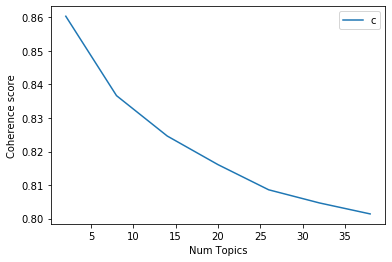

In [40]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [41]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.087*"film" + 0.050*"movie" + 0.028*"american" + 0.021*"story" + '
  '0.020*"love" + 0.017*"great" + 0.016*"long" + 0.011*"pretty" + 0.011*"war" '
  '+ 0.007*"able"'),
 (1,
  '0.021*"much" + 0.020*"life" + 0.020*"episode" + 0.018*"little" + '
  '0.017*"people" + 0.016*"real" + 0.016*"watch" + 0.015*"day" + 0.015*"many" '
  '+ 0.014*"way"'),
 (2,
  '0.038*"time" + 0.024*"series" + 0.019*"woman" + 0.018*"character" + '
  '0.013*"appearance" + 0.012*"romance" + 0.012*"end" + 0.010*"last" + '
  '0.009*"role" + 0.009*"sure"'),
 (3,
  '0.050*"first" + 0.034*"good" + 0.020*"actor" + 0.017*"anyone" + '
  '0.015*"stereotype" + 0.012*"year" + 0.010*"favorite" + 0.008*"due" + '
  '0.008*"comedy" + 0.008*"idea"'),
 (4,
  '0.017*"black" + 0.014*"white" + 0.013*"part" + 0.011*"high" + '
  '0.010*"america" + 0.009*"sport" + 0.009*"point" + 0.008*"nation" + '
  '0.008*"music" + 0.008*"realistic"')]


In [42]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.159329297408107

Coherence Score:  0.8425522171552995


In [43]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.142681  0.020437       1        1  21.022917
4      0.014735 -0.014193       2        1  20.904518
2      0.023552 -0.026165       3        1  20.799347
3      0.039068 -0.092926       4        1  19.614674
1      0.065326  0.112846       5        1  17.658543, topic_info=     Category       Freq     Term      Total  loglift  logprob
12    Default  85.000000     film  85.000000  30.0000  30.0000
3     Default  48.000000    movie  48.000000  29.0000  29.0000
52    Default  46.000000    first  46.000000  28.0000  28.0000
11    Default  36.000000     time  36.000000  27.0000  27.0000
60    Default  31.000000     good  31.000000  26.0000  26.0000
...       ...        ...      ...        ...      ...      ...
710    Topic5   2.673502    whole   3.255305   1.5371  -5.7186
496    Topic5   3.708482     help   4.528467   1.5342  -5.3914
1127   Topic5   3.101585    write   3.860698   1.5150  -5.5701
39     Topic5   4.668181  problem   7.508184   1.2587  -5.1613
1944   Topic5   3.221561  bronson  21.338104  -0.1567  -5.5322

[197 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
838       1  0.871495      able
711       5  0.806254       act
212       4  0.981313     actor
1309      2  0.938349   america
457       1  0.994434  american
...     ...       ...       ...
438       1  0.935294      work
704       5  0.843860     world
1127      5  0.777062     write
392       4  0.948920      year
108       3  0.865833     young

[173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

In [52]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.070*"movie" + 0.027*"watch" + 0.015*"funny" + 0.015*"people" + '
  '0.015*"scene" + 0.013*"plot" + 0.013*"colman" + 0.012*"dream" + '
  '0.012*"black" + 0.011*"young"'),
 (1,
  '0.040*"story" + 0.023*"thing" + 0.019*"day" + 0.018*"people" + '
  '0.016*"performance" + 0.014*"horror" + 0.014*"excellent" + 0.014*"war" + '
  '0.013*"book" + 0.012*"high"'),
 (2,
  '0.059*"good" + 0.044*"character" + 0.035*"life" + 0.033*"great" + '
  '0.022*"actor" + 0.018*"year" + 0.017*"long" + 0.016*"series" + 0.014*"star" '
  '+ 0.011*"cast"'),
 (3,
  '0.112*"film" + 0.027*"love" + 0.018*"part" + 0.017*"murder" + '
  '0.015*"american" + 0.015*"real" + 0.013*"show" + 0.013*"big" + 0.011*"guy" '
  '+ 0.010*"favorite"'),
 (4,
  '0.048*"time" + 0.042*"movie" + 0.026*"man" + 0.020*"brian" + 0.019*"woman" '
  '+ 0.015*"role" + 0.014*"family" + 0.014*"end" + 0.013*"scene" + '
  '0.013*"bad"')]

Coherence Score:  0.8461918601299041


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][2][2], corpus=good_bad[0][2][3], texts=good_bad[0][2][1], start=2, limit=40, step=6)


In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Topicos para entradas de avaliações negativas - Substantivo

In [47]:
pprint(good_bad[1][0][4].print_topics())
doc_lda = good_bad[1][0][4][good_bad[1][0][3]]

[(0,
  '0.058*"story" + 0.022*"scene" + 0.022*"work" + 0.018*"point" + '
  '0.017*"people" + 0.016*"waste" + 0.015*"actor" + 0.014*"book" + '
  '0.013*"level" + 0.011*"minute"'),
 (1,
  '0.022*"value" + 0.018*"cinema" + 0.017*"home" + 0.016*"tim" + '
  '0.016*"camera" + 0.016*"act" + 0.014*"score" + 0.014*"hour" + 0.014*"star" '
  '+ 0.013*"guy"'),
 (2,
  '0.130*"movie" + 0.028*"character" + 0.023*"budget" + 0.019*"way" + '
  '0.015*"top" + 0.014*"set" + 0.011*"love" + 0.011*"word" + 0.009*"man" + '
  '0.008*"sequence"'),
 (3,
  '0.174*"film" + 0.025*"credit" + 0.023*"director" + 0.016*"thing" + '
  '0.015*"approach" + 0.012*"picture" + 0.012*"money" + 0.012*"comparison" + '
  '0.012*"sound" + 0.010*"avoid"'),
 (4,
  '0.043*"time" + 0.032*"production" + 0.024*"nothing" + 0.023*"plot" + '
  '0.022*"end" + 0.020*"something" + 0.016*"lot" + 0.013*"king" + '
  '0.012*"merit" + 0.012*"life"')]


In [48]:
print('\nPerplexity: ', good_bad[1][0][4].log_perplexity(good_bad[1][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[1][0][4], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.596305986805142

Coherence Score:  0.8407370958462087


In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[1][0][4], good_bad[1][0][3], good_bad[1][0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.052378 -0.111581       1        1  24.147255
2     -0.065756  0.129369       2        1  20.384211
4     -0.020088 -0.014704       3        1  19.071377
3      0.159722  0.012696       4        1  18.299776
1     -0.021500 -0.015780       5        1  18.097378, topic_info=     Category       Freq        Term      Total  loglift  logprob
6     Default  95.000000        film  95.000000  30.0000  30.0000
38    Default  79.000000       movie  79.000000  29.0000  29.0000
80    Default  42.000000       story  42.000000  28.0000  28.0000
32    Default  25.000000        time  25.000000  27.0000  27.0000
126   Default  18.000000  production  18.000000  26.0000  26.0000
...       ...        ...         ...        ...      ...      ...
522    Topic5   2.074411         nee   2.664095   1.4592  -5.5613
192    Topic5   2.717022      change   3.553893   1.4409  -5.2914
1304   Topic5   8.828094         tim  16.524012   1.0825  -4.1130
647    Topic5   2.696467       doubt   3.564184   1.4304  -5.2990
1214   Topic5   4.280349       flick   8.669256   1.0037  -4.8369

[202 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
176       5  0.891235       act
105       1  0.905637     actor
243       2  0.694561  anything
969       4  0.912242  approach
108       1  0.768778       art
...     ...       ...       ...
371       1  0.978624      work
229       2  0.931118     world
40        4  0.948682    writer
190       5  0.900401      year
508       3  0.718334    zombie

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

In [50]:
pprint(good_bad[1][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[1][0][5], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.204*"movie" + 0.037*"scene" + 0.025*"director" + 0.019*"year" + '
  '0.015*"camera" + 0.013*"play" + 0.012*"case" + 0.012*"act" + 0.012*"lot" + '
  '0.010*"music"'),
 (1,
  '0.190*"film" + 0.025*"plot" + 0.020*"line" + 0.014*"credit" + 0.014*"cody" '
  '+ 0.014*"writer" + 0.012*"derek" + 0.010*"rest" + 0.010*"towelhead" + '
  '0.010*"run"'),
 (2,
  '0.062*"story" + 0.046*"character" + 0.020*"watch" + 0.020*"life" + '
  '0.018*"action" + 0.017*"gay" + 0.017*"people" + 0.015*"waste" + '
  '0.015*"money" + 0.013*"jane"'),
 (3,
  '0.096*"time" + 0.041*"thing" + 0.023*"love" + 0.021*"actor" + 0.018*"fact" '
  '+ 0.016*"world" + 0.016*"tv" + 0.016*"dialog" + 0.014*"tarzan" + '
  '0.014*"people"'),
 (4,
  '0.024*"work" + 0.024*"end" + 0.024*"minute" + 0.022*"man" + 0.021*"star" + '
  '0.019*"home" + 0.019*"production" + 0.019*"guy" + 0.019*"harris" + '
  '0.017*"set"')]

Coherence Score:  0.843402655482534


# Topicos para entradas de avaliações negativas - Adjetivos


In [53]:
pprint(good_bad[1][1][4].print_topics())
doc_lda = good_bad[1][1][4][good_bad[1][1][3]]

[(0,
  '0.128*"good" + 0.058*"short" + 0.035*"little" + 0.033*"low" + '
  '0.033*"horrible" + 0.028*"sure" + 0.027*"new" + 0.024*"american" + '
  '0.023*"main" + 0.023*"awful"'),
 (1,
  '0.072*"least" + 0.048*"great" + 0.047*"young" + 0.039*"terrible" + '
  '0.026*"interesting" + 0.022*"ridiculous" + 0.018*"serious" + '
  '0.016*"available" + 0.016*"exact" + 0.015*"hot"'),
 (2,
  '0.038*"regular" + 0.030*"hard" + 0.029*"fine" + 0.024*"real" + 0.020*"fast" '
  '+ 0.020*"academic" + 0.020*"valid" + 0.020*"gross" + 0.020*"popular" + '
  '0.020*"final"'),
 (3,
  '0.079*"first" + 0.053*"many" + 0.041*"pretty" + 0.029*"local" + '
  '0.027*"second" + 0.024*"single" + 0.024*"complete" + 0.018*"severe" + '
  '0.017*"kind" + 0.017*"long"'),
 (4,
  '0.212*"bad" + 0.058*"better" + 0.042*"much" + 0.033*"third" + 0.029*"worth" '
  '+ 0.026*"total" + 0.019*"important" + 0.017*"impress" + 0.015*"whole" + '
  '0.013*"korean"')]


In [54]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.027939777877369

Coherence Score:  0.8426443774438523


In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.153203 -0.191329       1        1  25.899643
0     -0.242262 -0.074773       2        1  21.450708
4      0.052749  0.179613       3        1  18.532391
3      0.025282  0.053979       4        1  17.186779
2      0.011028  0.032510       5        1  16.930475, topic_info=    Category       Freq        Term      Total  loglift  logprob
13   Default  38.000000       first  38.000000   30.000  30.0000
17   Default  33.000000        good  33.000000   29.000  29.0000
0    Default  18.000000       great  18.000000   28.000  28.0000
14   Default  17.000000        much  17.000000   27.000  27.0000
123  Default  16.000000    american  16.000000   26.000  26.0000
..       ...        ...         ...        ...      ...      ...
458   Topic5   1.568674    negative   2.136706    1.467  -4.8605
449   Topic5   1.568674    solitary   2.136706    1.467  -4.8605
453   Topic5   1.568674     certain   2.136706    1.467  -4.8605
455   Topic5   1.568674  mysterious   2.136706    1.467  -4.8605
454   Topic5   1.568674    apparent   2.136706    1.467  -4.8605

[212 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
216       3  0.991925        able
472       5  0.936020  acceptable
480       1  0.734832      actual
69        1  0.892497     amazing
123       1  0.966253    american
...     ...       ...         ...
187       2  0.829345       whole
163       4  0.822508        wise
462       5  0.936020  worthwhile
185       2  0.683909       wrong
27        2  0.988036       young

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3])

In [56]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.089*"early" + 0.064*"real" + 0.050*"high" + 0.035*"poor" + 0.025*"sad" + '
  '0.025*"live" + 0.020*"dark" + 0.020*"remarkable" + 0.020*"portray" + '
  '0.020*"white"'),
 (1,
  '0.056*"american" + 0.051*"black" + 0.046*"favorite" + 0.046*"pretty" + '
  '0.046*"young" + 0.031*"enjoyable" + 0.026*"kind" + 0.021*"powerful" + '
  '0.021*"easy" + 0.021*"special"'),
 (2,
  '0.082*"long" + 0.065*"big" + 0.033*"full" + 0.027*"interesting" + '
  '0.022*"small" + 0.022*"average" + 0.022*"due" + 0.022*"sexual" + '
  '0.016*"lovely" + 0.016*"clear"'),
 (3,
  '0.151*"great" + 0.062*"bad" + 0.031*"usual" + 0.031*"general" + '
  '0.026*"normal" + 0.021*"worth" + 0.021*"late" + 0.021*"white" + '
  '0.021*"classic" + 0.021*"amazing"'),
 (4,
  '0.263*"good" + 0.061*"funny" + 0.061*"excellent" + 0.040*"beautiful" + '
  '0.025*"british" + 0.025*"fit" + 0.025*"complete" + 0.020*"disappoint" + '
  '0.020*"loud" + 0.015*"regular"')]

Coherence Score:  0.8443817389031576


# Topicos para entradas de avaliações negativas - Substantivos + Adjetivos


In [57]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.087*"film" + 0.050*"movie" + 0.028*"american" + 0.021*"story" + '
  '0.020*"love" + 0.017*"great" + 0.016*"long" + 0.011*"pretty" + 0.011*"war" '
  '+ 0.007*"able"'),
 (1,
  '0.021*"much" + 0.020*"life" + 0.020*"episode" + 0.018*"little" + '
  '0.017*"people" + 0.016*"real" + 0.016*"watch" + 0.015*"day" + 0.015*"many" '
  '+ 0.014*"way"'),
 (2,
  '0.038*"time" + 0.024*"series" + 0.019*"woman" + 0.018*"character" + '
  '0.013*"appearance" + 0.012*"romance" + 0.012*"end" + 0.010*"last" + '
  '0.009*"role" + 0.009*"sure"'),
 (3,
  '0.050*"first" + 0.034*"good" + 0.020*"actor" + 0.017*"anyone" + '
  '0.015*"stereotype" + 0.012*"year" + 0.010*"favorite" + 0.008*"due" + '
  '0.008*"comedy" + 0.008*"idea"'),
 (4,
  '0.017*"black" + 0.014*"white" + 0.013*"part" + 0.011*"high" + '
  '0.010*"america" + 0.009*"sport" + 0.009*"point" + 0.008*"nation" + '
  '0.008*"music" + 0.008*"realistic"')]


In [58]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.159329349668837

Coherence Score:  0.8425522171552995


In [59]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.142681  0.020437       1        1  21.022924
4      0.014735 -0.014193       2        1  20.904526
2      0.023552 -0.026165       3        1  20.799349
3      0.039068 -0.092926       4        1  19.614679
1      0.065326  0.112846       5        1  17.658527, topic_info=     Category       Freq     Term      Total  loglift  logprob
12    Default  85.000000     film  85.000000  30.0000  30.0000
3     Default  48.000000    movie  48.000000  29.0000  29.0000
52    Default  46.000000    first  46.000000  28.0000  28.0000
11    Default  36.000000     time  36.000000  27.0000  27.0000
60    Default  31.000000     good  31.000000  26.0000  26.0000
...       ...        ...      ...        ...      ...      ...
710    Topic5   2.673500    whole   3.255303   1.5371  -5.7186
496    Topic5   3.708480     help   4.528465   1.5342  -5.3914
1127   Topic5   3.101583    write   3.860696   1.5150  -5.5701
39     Topic5   4.668178  problem   7.508182   1.2587  -5.1613
1944   Topic5   3.221559  bronson  21.338108  -0.1567  -5.5322

[197 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
838       1  0.871495      able
711       5  0.806255       act
212       4  0.981313     actor
1309      2  0.938349   america
457       1  0.994433  american
...     ...       ...       ...
438       1  0.935294      work
704       5  0.843860     world
1127      5  0.777062     write
392       4  0.948920      year
108       3  0.865833     young

[173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

In [60]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.070*"movie" + 0.027*"watch" + 0.015*"funny" + 0.015*"people" + '
  '0.015*"scene" + 0.013*"plot" + 0.013*"colman" + 0.012*"dream" + '
  '0.012*"black" + 0.011*"young"'),
 (1,
  '0.040*"story" + 0.023*"thing" + 0.019*"day" + 0.018*"people" + '
  '0.016*"performance" + 0.014*"horror" + 0.014*"excellent" + 0.014*"war" + '
  '0.013*"book" + 0.012*"high"'),
 (2,
  '0.059*"good" + 0.044*"character" + 0.035*"life" + 0.033*"great" + '
  '0.022*"actor" + 0.018*"year" + 0.017*"long" + 0.016*"series" + 0.014*"star" '
  '+ 0.011*"cast"'),
 (3,
  '0.112*"film" + 0.027*"love" + 0.018*"part" + 0.017*"murder" + '
  '0.015*"american" + 0.015*"real" + 0.013*"show" + 0.013*"big" + 0.011*"guy" '
  '+ 0.010*"favorite"'),
 (4,
  '0.048*"time" + 0.042*"movie" + 0.026*"man" + 0.020*"brian" + 0.019*"woman" '
  '+ 0.015*"role" + 0.014*"family" + 0.014*"end" + 0.013*"scene" + '
  '0.013*"bad"')]

Coherence Score:  0.8461918601299041
